# P1 - Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [2]:
!pip -q install ./python
!pip install torchsummary

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [3]:
from unityagents import UnityEnvironment
import numpy as np
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

(from https://github.com/udacity/deep-reinforcement-learning/tree/master/p1_navigation)

This project trains an agent to navigate (and collect bananas) in a large, square world.

A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal of your agent is to collect as many yellow bananas as possible while avoiding blue bananas.

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction. Given this information, the agent has to learn how to best select actions. Four discrete actions are available, corresponding to:

+ 0 - move forward.

+ 1 - move backward.

+ 2 - turn left.

+ 3 - turn right.

The task is episodic, and in order to solve the environment, the agent must get an average score of +13 over 100 consecutive episodes.

<br>
<center>
<img src="https://user-images.githubusercontent.com/10624937/42135619-d90f2f28-7d12-11e8-8823-82b970a54d7e.gif">
</center>
<br>

Run the code cell below to print some information about the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]
print('Number of agents:', len(env_info.agents))
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)
state = env_info.vector_observations[0]
# print('States look like:', state)
print('States have length:', len(state))

Number of agents: 1
Number of actions: 4
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [6]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [8]:
# env.close()

<font color="blue"><h1>Implementation</h1></font>
<hr>

The implementation is largely based on the 'LunarLander-v2' example given in Lesson 2: Deep Q-Networks.
The main adaptation was using a Unity environment instead of the OpenAI Gym environment.

## Model

We will use a Deep Neural Network as the function approximator for the Q function. The chosen DNN architecture is a 3 layer fully connected neural network with the input layer dimension being 37, the first hidden layer being 64 dimensional, the second hidden layer also being 64 dimensional, and the final output layer being 4 dimensional (for each different action). 

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """
        state_size (int): Dimension of each state
        action_size (int): Dimension of each action
        seed (int): Random seed
        """

        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        

    def forward(self, state):
        """Build a network that maps state -> action values."""
        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [18]:
from torchsummary import summary
model = QNetwork(37, 4, 0)
summary(model, input_size=(37,-1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           2,432
            Linear-2                   [-1, 64]           4,160
            Linear-3                    [-1, 4]             260
Total params: 6,852
Trainable params: 6,852
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


## Agent

The model will be trained using Gradient Descent with the **Adam optimizer** to update the weights.

Nonlinear function approximators like neural networks can run into instabilities. To help improve convergence, two modifications will be made:

+  **Experience Replay** -  To avoid learning experiences in sequence (which will lead to correlations between them) we store all the experience tuples (state, action, reward, and next state) in a memory buffer. The agent will learn from randomly sampled experiences from this buffer. This also helps us learn from the same experience multiple times, which is especially useful when encountering rare experiences. 

+ **Fixed Q-values** - The TD target is also dependent on the network parameter w that we are trying to learn/update, and this can lead to instabilities. To address it, a separate network with identical architecture but different weights is used. 
The target network gets updated slowly according to the hyperparameter TAU while the local network aggressively “learns” with each update. At a high level, this loss function is taking the squared error between a conservative/stable estimate of the value of state 𝑠 and action 𝑎 (the actual reward received plus the discounted value from the more stable target model) and the more aggressive guess of that value prior to taking action 𝑎.

The learning algorithm uses an **Epislon Greedy algorithm** to select actions while being trained. The epsilon represents the probability of choosing an action at random instead of following what is currently expected to be the “best” action in the given state (exploration vs. exploitation). 

The Agent class defines how an agent acts when asked to provide an action, learn from a time step, update the target network and manages the memory buffer.

In [19]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        
        # Get Q action values from state
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        # Get max predicted Q-values (for next state) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q targets from current model
        Q_targets = rewards + (gamma * Q_targets_next * (1- dones))
        
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

To use Experience Replay we define a memory buffer class. An object of ReplayBuffer initializes a deque to store the experience tuples. It has methods to store a new experience tuple and to return a sample of experiences of a given batch_size.

In [20]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Trainig the DQN

The following code corresponds to the DQN algorithm.
It returns the list of scores for all episodes and terminates when a value >= 13.0 of the average score over the last 100 episodes is achieved.

Epsilon decays from a starting value eps_start=1.0 until it reaches a minimal value of eps_end=0.001 with eps_decay=0.995.

In [21]:
import matplotlib.pyplot as plt

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):

        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0] 
        score = 0
        
        
        for t in range(max_t):
            
            action = agent.act(state, eps)                 # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            if done:
                break 
                

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores


## Train Agent

The following code initializes an Agent object and runs the DQN algorithm.

Episode 100	Average Score: 1.26
Episode 200	Average Score: 4.45
Episode 300	Average Score: 7.81
Episode 400	Average Score: 10.92
Episode 500	Average Score: 12.38
Episode 533	Average Score: 13.06
Environment solved in 433 episodes!	Average Score: 13.06


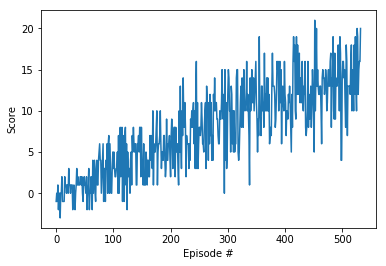

In [22]:
# Initiate Agent
agent = Agent(state_size=37, action_size=4, seed=0)

# Train Agent and get scores
scores = dqn()

# Close Environment
# env.close()

# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

<font color="blue">
An average score > 13.0 over the last 100 episodes was achieved at <b>433</b> episodes.
</font>

## Test loaded model

The weights of the trained model are saved in 'checkpoint.pth'.
We can use these weights to test our trained model.

In [25]:
# Initiate Agent
agent = Agent(state_size=37, action_size=4, seed=0)

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

            
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))
            
# env.close()

Score: 14.0
